In [1]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [2]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [3]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [4]:
symbol = 'ETH/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [5]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [6]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver4.0 y el notebook es red_neuronal_mlp.ipynb


In [7]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver4.1')
from ft_transformer_model import torch,model, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind = df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

# Preparar los nuevos datos
X_nuevos = df_ind[features]
X_nuevos = X_nuevos.dropna()

# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

# Convertir los datos a tensores de PyTorch
X_nuevos_tensor = torch.tensor(X_nuevos_scaled, dtype=torch.float32)

# Realizar predicciones en los nuevos datos
model.eval()  # Establecer el modelo en modo de evaluación (desactiva el dropout y batch normalization)
with torch.no_grad():  # Desactivar el cálculo de gradientes
    outputs = model(X_nuevos_tensor)  # Obtener las salidas del modelo
    predicciones = torch.argmax(outputs, dim=1)  # Obtener las predicciones (la clase con mayor probabilidad)

# Añadir las predicciones al DataFrame
df_df_ind = df_df_ind.loc[X_nuevos.index]  # Asegura que coincidan los índices
df_df_ind["predicted_signals"] = predicciones.numpy()  # Convertir las predicciones a un array de numpy



c:\Users\POZOLE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.7761
Epoch 2/50, Loss: 0.7296
Epoch 3/50, Loss: 0.6551
Epoch 4/50, Loss: 0.6006
Epoch 5/50, Loss: 0.5811
Epoch 6/50, Loss: 0.5504
Epoch 7/50, Loss: 0.5303
Epoch 8/50, Loss: 0.5388
Epoch 9/50, Loss: 0.5503
Epoch 10/50, Loss: 0.5348
Epoch 11/50, Loss: 0.5183
Epoch 12/50, Loss: 0.4980
Epoch 13/50, Loss: 0.5281
Epoch 14/50, Loss: 0.5162
Epoch 15/50, Loss: 0.4884
Epoch 16/50, Loss: 0.4850
Epoch 17/50, Loss: 0.5018
Epoch 18/50, Loss: 0.4847
Epoch 19/50, Loss: 0.4694
Epoch 20/50, Loss: 0.4699
Epoch 21/50, Loss: 0.4697
Epoch 22/50, Loss: 0.4546
Epoch 23/50, Loss: 0.4709
Epoch 24/50, Loss: 0.4911
Epoch 25/50, Loss: 0.4739
Epoch 26/50, Loss: 0.4776
Epoch 27/50, Loss: 0.4762
Epoch 28/50, Loss: 0.4537
Epoch 29/50, Loss: 0.4680
Epoch 30/50, Loss: 0.4587
Epoch 31/50, Loss: 0.4637
Epoch 32/50, Loss: 0.4530
Epoch 33/50, Loss: 0.4332
Epoch 34/50, Loss: 0.4400
Epoch 35/50, Loss: 0.4320
Epoch 36/50, Loss: 0.4276
Epoch 37/50, Loss: 0.4211
Epoch 38/50, Loss: 0.4028
Epoch 39/50, Loss: 0.

In [8]:
import numpy as np

# Opcional: convertir las predicciones numéricas de vuelta a texto
inverse_mapping = {0: 'buy', 1: 'sell', 2: 'hold'}
df_df_ind['predictions_text'] = df_df_ind['predicted_signals'].map(inverse_mapping)

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predictions_text'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predictions_text'] == 'sell', 1, 0)


In [9]:
df_df_ind.head(n=60)

,date,open,high,low,close,volume,value,value_classification,rsi,macd,...,dri,dlogri,avgtr,donch_hband,donch_lband,vwap,predicted_signals,predictions_text,buy_signal,sell_signal
25,2022-08-01,1678.53,1704.67,1606.64,1630.31,25131.95348,39,Fear,61.377695,108.238847,...,-2.872752,-2.914823,121.457217,1784.00,1006.39,1584.619337,2,hold,0,0
26,2022-08-02,1630.31,1678.71,1558.18,1630.25,30489.82907,33,Fear,61.372068,103.004959,...,-0.003680,-0.003680,121.390987,1784.00,1072.10,1590.895331,2,hold,0,0
27,2022-08-03,1630.25,1684.81,1588.48,1618.65,23862.76783,31,Fear,60.222599,96.805133,...,-0.711547,-0.714091,119.600917,1784.00,1181.06,1598.158604,2,hold,0,0
28,2022-08-04,1618.65,1662.84,1581.17,1608.20,29571.25863,34,Fear,59.147847,90.010909,...,-0.645600,-0.647693,116.891566,1784.00,1191.94,1604.727991,2,hold,0,0
29,2022-08-05,1608.20,1741.84,1605.62,1736.64,35952.92229,30,Fear,66.953992,93.907960,...,7.986569,7.683667,118.272168,1784.00,1317.82,1614.596214,2,hold,0,0
30,2022-08-06,1736.64,1749.99,1684.10,1690.86,20204.77580,31,Fear,62.378706,92.239062,...,-2.636125,-2.671494,114.530585,1784.00,1335.76,1622.990560,2,hold,0,0
31,2022-08-07,1690.86,1729.71,1668.56,1700.33,16757.08048,31,Fear,62.942828,90.635806,...,0.560070,0.558507,110.717686,1784.00,1356.67,1627.059098,2,hold,0,0
32,2022-08-08,1700.33,1818.30,1694.33,1777.21,28021.17873,30,Fear,67.237800,94.479684,...,4.521475,4.422237,111.664280,1818.30,1356.67,1647.906333,2,hold,0,0
33,2022-08-09,1777.21,1790.67,1668.64,1702.66,25815.91318,30,Fear,59.978383,90.467570,...,-4.194777,-4.285298,112.404688,1818.30,1356.67,1673.626482,2,hold,0,0
34,2022-08-10,1702.66,1885.00,1655.04,1854.64,35394.03917,42,Fear,67.647132,98.416966,...,8.926033,8.549887,120.801496,1885.00,1356.67,1697.046763,2,hold,0,0


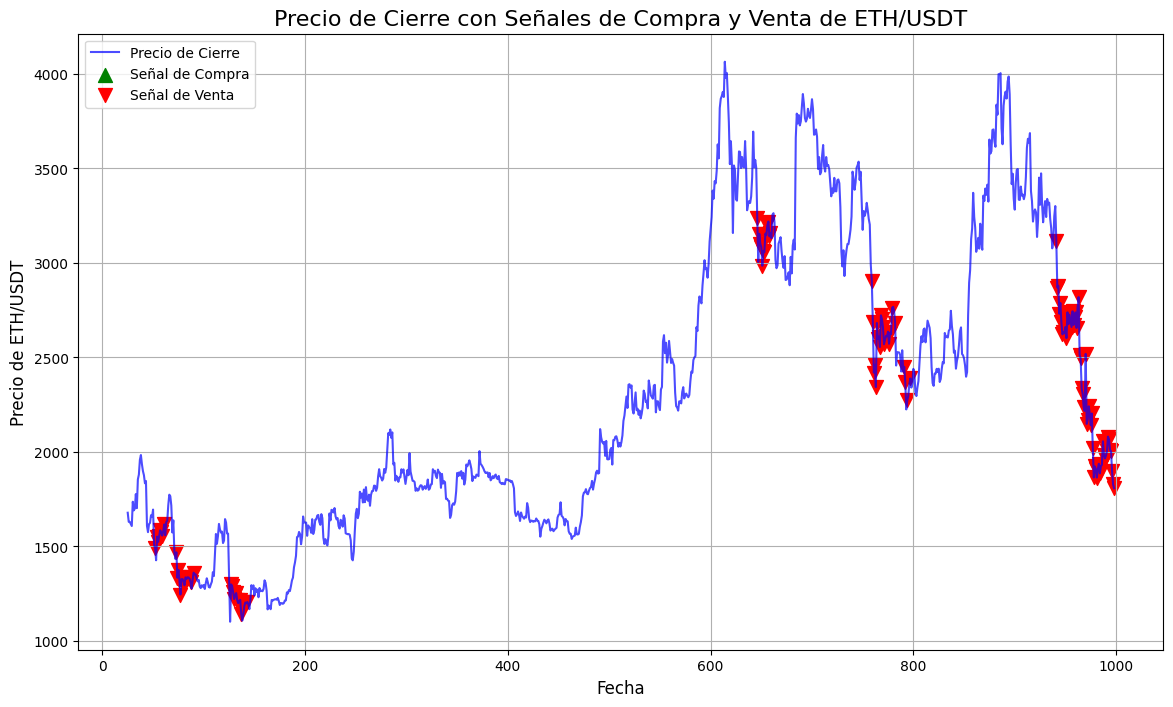

In [10]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title(f'Precio de Cierre con Señales de Compra y Venta de {symbol}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {symbol}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Capital final: 1000.00 USDT


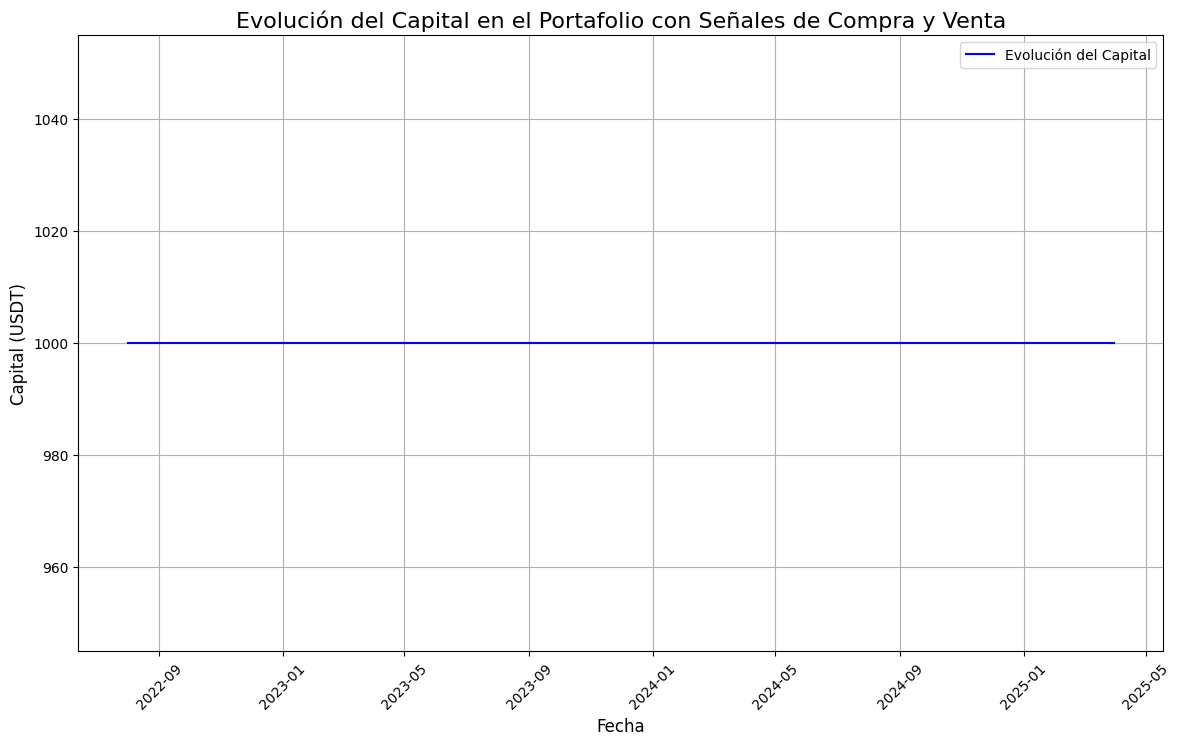

In [11]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 287604.63 USDT
Tasa de Retorno Acumulado: 28660.46%
Volatilidad Anualizada: 0.5226
Relación de Sharpe: -0.0180
Drawdown Máximo: 0.00%


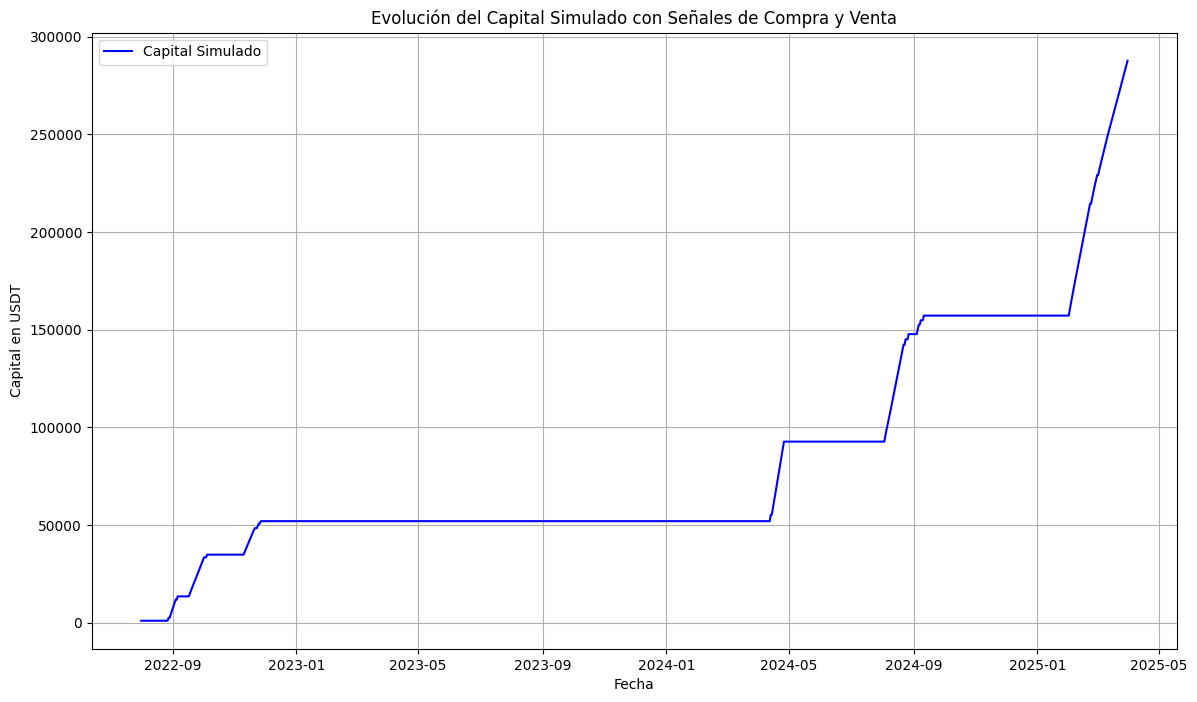

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Capital final: 1000.00 USDT
